# Introduction
In the lecture, you have seen that Image optimizer were composed of three main components.
* Data (training/validation/test): $\{x_i,y_i\}$
* Scoring Function (Probability to belong to class k): $f(x_i,\mathbf{W})$
* Loss Function: $L_i(W) = h(f(x_i,W),y_i) \quad L(W) = \frac{1}{N}\sum_i L_i(W)$

The scoring function is defined by a set of parameters $W$ that we want to estimate to minimize the loss function. $W$ is estimate through optimization:
$$W = \arg\min L(W) = \arg\min \sum_i \frac{1}{N}L_i(W)$$

The following points will be seen during this lab session:

1 - **Visualising a loss function**

2 - **First Approach to Optimisation: Random Search**

3 - **Second Approach to Optimisation: First Order method and Moments**

4 - **Third Approach to Optimisation: Second Order method**

5 - **Applying Gradient Descent and Stochastic Gradient Descent on a mockup dataset**

We will start by briefly learning how to visualise loss functions to better understand the loss landscape and where we should be careful about the optimisation.

## Visualising the loss function

The loss function is a function taking as input a n-dimensional vector with n being the size of the parameter matrix W that we want to minimise. Matplotlib offers a wide range of visualisation tools to visualise such function. Let's see what can be done for 2d-input functions such as the following function $f:(x_i,x_j)\to x_i^2+x_j^2$.

In [1]:
# Importation of useful packages
import numpy as np
import scipy.optimize
import numdifftools as nd
import matplotlib.pyplot as plt

In [2]:
def function_to_plot_2d(x1,x2):
    value = x1**2 + x2**2
    return value

The following Python function will visualize the input function on a 2D grid. It will produce three different graphs:
* **2D color map**: the x and y axis represent the two variables' values and the color pixel represent the value of the loss for a given (x,y)
* **Surface Plot**: the surface plot represent the loss value as the z-axis instead.
* **Iso-contour**: the iso-contour shows the input values (x,y) that will produce the same loss value. For example, the iso-contour at level 0 is the set of values (x,y) such that f(x,y)=0.

In [3]:
def visualization_func(grid_x, grid_y, function_values, w=None, xlim=[-1,1], ylim=[-1,1], zlim=[0,2], contour_values=[0.5]):
    # Create the matplotlib figure
    fig = plt.figure(figsize=plt.figaspect(0.3))
    # Add the first subplot, known as an 'Axes' object in matplotlib
    ax = fig.add_subplot(1, 3, 1)
    # Produce an image plot of the values. By default, values are interpolated
    # between points to produce a smooth visual.
    ax.imshow(function_values, extent=[xlim[0], xlim[1], ylim[0], ylim[1]], origin='lower')
    if w is not None:
        ax.plot(w[0],w[1], marker='o', color='r')
    ax.set_title('Image plot of function values')
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    # Produce another plot of these values, this time as a surface in 3D space.
    surf = ax.plot_surface(grid_x, grid_y, function_values, rstride=1, cstride=1, linewidth=0, antialiased=False)
    ax.set_zlim3d(zlim[0], zlim[1])
    ax.set_title('Mesh plot of function values')
    ax = fig.add_subplot(1, 3, 3)
    # Plot some contour lines of our function. Again, these are automatically
    # interpolated from the values.
    CS = ax.contour(grid_x, grid_y, function_values, contour_values,cmap=plt.cm.winter)
    ax.clabel(CS)
    ax.set_title('Isocontours of function')
    # Finally, show the figure.
    plt.show()

We can now visualise the function f $f:(x_i,x_j)\to x_i^2+x_j^2$ using the previous visualisation function:

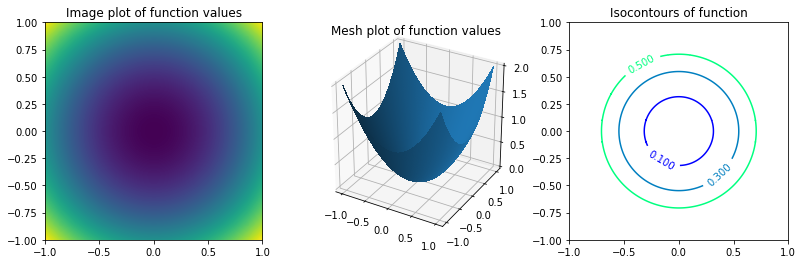

In [4]:
num_of_points = 201
# Linearly sample the [-1,1] interval with the given number of points.
x1 = np.linspace(-1.0, 1.0, num=num_of_points)
x2 = np.linspace(-1.0, 1.0, num=num_of_points)
# Create a rectangular grid out of the x1 and x2 values.
X1, X2 = np.meshgrid(x1, x2, sparse=False)
visualization_func(X1, X2, function_to_plot_2d(X1,X2), contour_values=[0.1,0.3,0.5])

The previous function is a convex function but in most cases, the loss function has a much more complicated surface.

For example, let's define and plot the Himmelblau function: $f:(x_i,x_j)\to (x_i^2+x_j-11)^2 + (x_i+x_j^2-7)$ 

In [5]:
def function_himmelblau(x1,x2):
    return (x1**2+x2-11)**2 + (x1+x2**2-7)**2

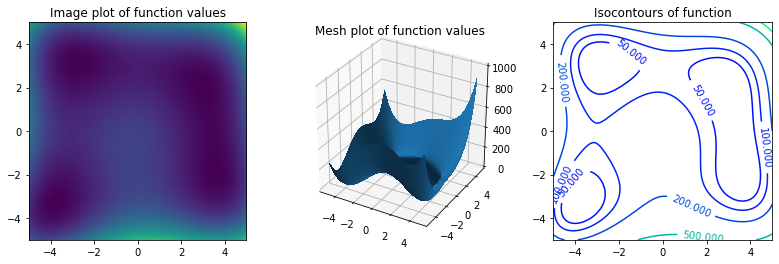

In [6]:
num_of_points = 201
# Linearly sample the [-5,5] interval with the given number of points.
x1 = np.linspace(-5.0, 5.0, num=num_of_points)
x2 = np.linspace(-5.0, 5.0, num=num_of_points)
# Create a rectangular grid out of the x1 and x2 values.
X1, X2 = np.meshgrid(x1, x2, sparse=False)
visualization_func(X1, X2, function_himmelblau(X1,X2), xlim=[-5,5], ylim=[-5,5], zlim=[0,1000], contour_values=[0,50,100,200,500,700])

The function is not convex anymore and is composed of multiple local minima. Multiple local minima can be challenging as an optimiser can easily be stuck in one of them with no chance to find the correct global minimum.

But even simpler function can lead to bad optimization behavior such as saddle points.

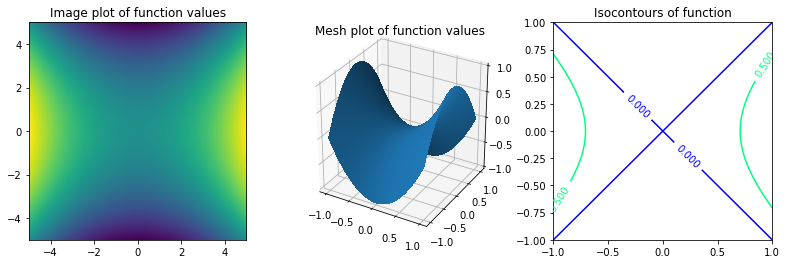

In [7]:
def function_saddle_point(x1,x2):
    value = x1**2 - x2**2 
    return value

num_of_points = 201
# Linearly sample the [-1,1] interval with the given number of points.
x1 = np.linspace(-1.0, 1.0, num=num_of_points)
x2 = np.linspace(-1.0, 1.0, num=num_of_points)
# Create a rectangular grid out of the x1 and x2 values.
X1, X2 = np.meshgrid(x1, x2, sparse=False)
visualization_func(X1, X2, function_saddle_point(X1,X2), xlim=[-5,5], ylim=[-5,5], zlim=[-1,1], contour_values=[0.0,0.5])

The functions displayed so far are limited to 2d-input functions. However, one may want to visualise the function with higher dimensional inputs. How can this be done for such more complicated functions?

Such visualisation can be designed at the price of loosing some information. Some helpful visualisation can be obtained by slicing through the high-dimensional space along rays (1 dimension), or along planes (2 dimensions).

Let's consider the same simple function as above but now, with a third dimension input: $f:(x_i,x_j,x_k)\to x_i^2+x_j^2+x_k^2$ 

In [8]:
def function_to_plot_3d(x1,x2,x3):
    value = x1**2 + x2**2 + x3**2
    return value

Example 1 - 1D: generate and random weight matrix W (which corresponds to a single point in the space) and evaluate the loss function along a ray of random direction $W_1$, $L(W+aW1)$ with $a$ within the display range. This process generates a simple plot with the value of a as the x-axis and the value of the loss function as the y-axis.

In [9]:
def ray_slicing(init_weigth, function):
    unormalized_random_direction = np.random.randn(len(init_weigth))
    normalized_random_direction = unormalized_random_direction / np.linalg.norm(unormalized_random_direction)
    def sliced_function(x):
        dim_weight = init_weigth.shape[0]
        input_vector = np.expand_dims(init_weigth, axis=0) + np.expand_dims(x, axis=1) * np.expand_dims(normalized_random_direction, axis=0)
        values = function(*(input_vector[:,i] for i in range(dim_weight)))
        return values
    return sliced_function

Text(0.5, 1.0, 'Ray Slicing representation of f(x)')

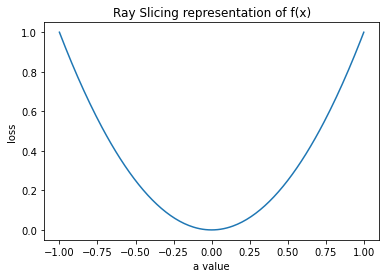

In [10]:
init_weigth = np.zeros([3])
sliced_function = ray_slicing(init_weigth, function_to_plot_3d)

num_of_points = 201
# Linearly sample the [-1,1] interval with the given number of points.
a = np.linspace(-1.0, 1.0, num=num_of_points)
# Create a rectangular grid out of the x1 and x2 values.
plt.plot(a, sliced_function(a))
plt.xlabel('a value')
plt.ylabel('loss')
plt.title('Ray Slicing representation of f(x)')

Example 2 - 2D: generate and random weight matrix W and evaluate the loss function along a plane of random normal orthogonal to both $W_1$ and $W_2$, $L(W+aW1+bW_2)$ with $a$ and $b$ within the display range. In the plot, a,b would then correspond to the x-axis and the y-axis, and the value of the loss function can be visualized with colors or as a third dimension.

In [11]:
def plane_slicing(init_weigth, function):
    # Creating W1
    unormalized_random_direction1 = np.random.randn(len(init_weigth))
    normalized_random_direction1 = unormalized_random_direction1 / np.linalg.norm(unormalized_random_direction1)
    # Creating W2
    unormalized_random_direction2 = np.random.randn(len(init_weigth))
    normalized_random_direction2 = unormalized_random_direction2 / np.linalg.norm(unormalized_random_direction2)
    def sliced_function(x,y):
        shape_input = x.shape
        x = np.reshape(x, [-1])
        y = np.reshape(y, [-1])
        dim_weight = init_weigth.shape[0]
        input_vector = np.expand_dims(init_weigth, axis=0) + \
            np.expand_dims(x, axis=1) * np.expand_dims(normalized_random_direction1, axis=0) + \
            np.expand_dims(y, axis=1) * np.expand_dims(normalized_random_direction2, axis=0)
        values = function(*(input_vector[:,i] for i in range(dim_weight)))
        values = np.reshape(values, shape_input)
        return values
    return sliced_function

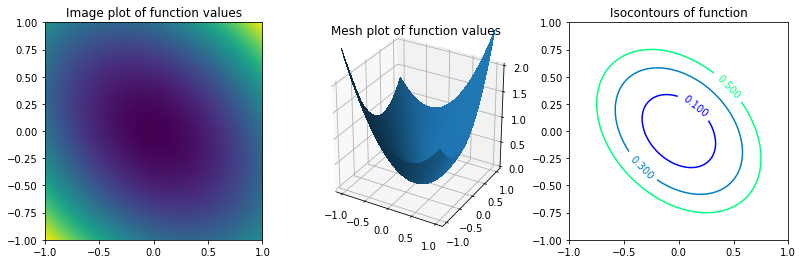

In [12]:
init_weigth = np.zeros([3])
sliced_function = plane_slicing(init_weigth, function_to_plot_3d)

num_of_points = 201
# Linearly sample the [-1,1] interval with the given number of points.
x1 = np.linspace(-1.0, 1.0, num=num_of_points)
x2 = np.linspace(-1.0, 1.0, num=num_of_points)
# Create a rectangular grid out of the x1 and x2 values.
X1, X2 = np.meshgrid(x1, x2, sparse=False)
visualization_func(X1, X2, sliced_function(X1,X2), contour_values=[0.1,0.3,0.5])

Neural networks, that will be explained later in the module, have millions of parameters and as such, the loss function cannot be easily analyzed.

## First Approach: Random search
Since it is simple to evaluate how good a given set of parameters W is, the first idea that may come to mind is to simply try out many different random weights and keep track of what works best. This procedure looks as follow:

In [13]:
def random_search(initW, botLimW, upLimW, loss_function, nb_iter=100):
    history_loss = []
    bestLoss = loss_function(*initW)
    history_loss.append(bestLoss)
    currW = initW
    for iter_ in range(nb_iter):
        W = (upLimW-botLimW)/2 * ((np.random.rand(*initW.shape)-0.5) + (botLimW+upLimW)/2)
        loss = loss_function(*W)
        if loss < bestLoss:
            bestLoss = loss
            currW = W
        history_loss.append(bestLoss)
    return currW, history_loss

A second method consists in checking for better parameter values W in the local neighborhood of the best parameter value found so far. By doing so, the optimisation will mostly focus on the most promising areas. However, this second method can lead to being stuck in bad local minima.

In [14]:
def random_search_pp(initW, loss_function, stepsize=0.01, nb_iter=100):
    history_loss = []
    bestLoss = loss_function(*initW)
    history_loss.append(bestLoss)
    W = initW
    for iter_ in range(nb_iter):
        W_local = W + stepsize * np.random.randn(*initW.shape)
        loss = loss_function(*W_local)
        if loss < bestLoss:
            bestLoss = loss
            W = W_local
        history_loss.append(bestLoss)
    return W, history_loss

Let's compare both approaches by trying to find the minima of the function: $f:(x_i,x_j)\to x_i^2+x_j^2$ 

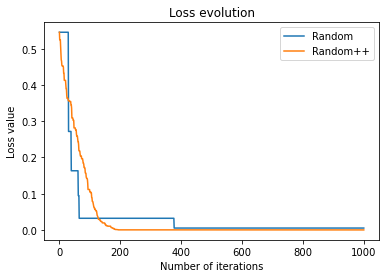

Ground Truth Value:  [0. 0.]
Results from Random Search:  [-0.0707973  -0.01113566]


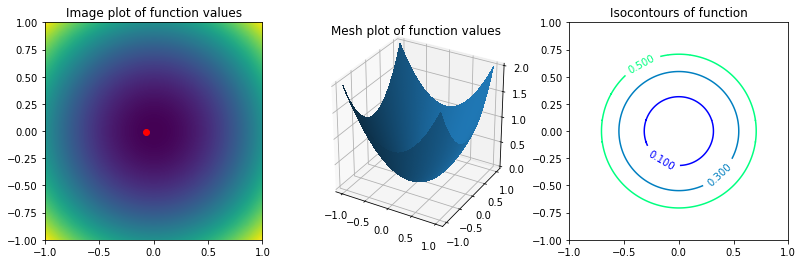

Results from Random Search ++ [-0.00016362 -0.00014905]


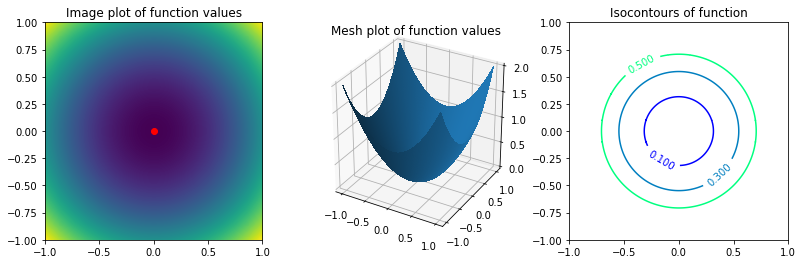

In [15]:
def sum_square_function(w1, w2):
    value = w1**2 + w2**2
    return value
initW = np.random.randn(2)
botLimW = np.array([-5,-5])
upLimW = np.array([5,5])
w, loss = random_search(initW, botLimW, upLimW, sum_square_function, nb_iter=1000)
w_pp, loss_pp = random_search_pp(initW, sum_square_function, nb_iter=1000)

plt.plot(loss, label='Random')
plt.plot(loss_pp, label='Random++')
plt.xlabel("Number of iterations")
plt.ylabel("Loss value")
plt.legend(loc="upper right")
plt.title('Loss evolution')
plt.show()

num_of_points = 201
# Linearly sample the [-1,1] interval with the given number of points.
x1 = np.linspace(-1.0, 1.0, num=num_of_points)
x2 = np.linspace(-1.0, 1.0, num=num_of_points)
# Create a rectangular grid out of the x1 and x2 values.
X1, X2 = np.meshgrid(x1, x2, sparse=False)
print('Ground Truth Value: ', np.zeros([2]))
print('Results from Random Search: ', w)
visualization_func(X1, X2, sum_square_function(X1,X2), w=w, contour_values=[0.1,0.3,0.5])
print('Results from Random Search ++', w_pp)
visualization_func(X1, X2, sum_square_function(X1,X2), w=w_pp, contour_values=[0.1,0.3,0.5])

and for the function $f:(x_i,x_j)\to (x_i^2+x_j-11)^2 + (x_i+x_j^2-7)$ 

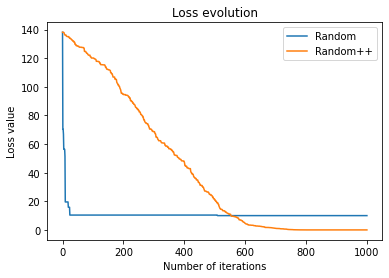

Ground Truth Value: 
 [[ 3.        2.      ]
 [-2.805118  3.131312]
 [-3.77931  -3.283186]
 [ 3.584428 -1.848126]]
Results from Random Search:  [2.41193388 2.04670784]


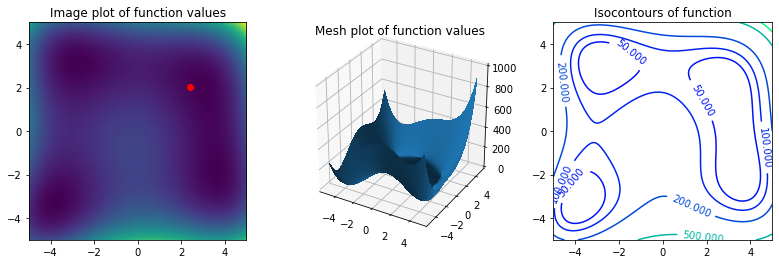

Results from Random Search ++ [ 3.58423541 -1.84885662]


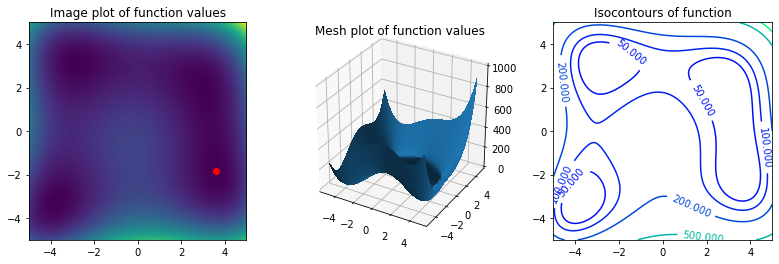

In [16]:
def himmelblau_function(w1, w2):
    return (w1**2+w2-11)**2 + (w1+w2**2-7)**2
initW = np.random.randn(2)
botLimW = np.array([-5,-5])
upLimW = np.array([5,5])
w, loss = random_search(initW, botLimW, upLimW, himmelblau_function, nb_iter=1000)
w_pp, loss_pp = random_search_pp(initW, himmelblau_function, nb_iter=1000)

plt.plot(loss, label='Random')
plt.plot(loss_pp, label='Random++')
plt.xlabel("Number of iterations")
plt.ylabel("Loss value")
plt.legend(loc="upper right")
plt.title('Loss evolution')
plt.show()

num_of_points = 201
# Linearly sample the [-1,1] interval with the given number of points.
x1 = np.linspace(-5.0, 5.0, num=num_of_points)
x2 = np.linspace(-5.0, 5.0, num=num_of_points)
# Create a rectangular grid out of the x1 and x2 values.
print('Ground Truth Value: \n', np.array([[3.0, 2.0],\
                                       [-2.805118,3.131312],\
                                       [-3.779310,-3.283186],\
                                       [3.584428,-1.848126]]))
X1, X2 = np.meshgrid(x1, x2, sparse=False)
print('Results from Random Search: ', w)
visualization_func(X1, X2, himmelblau_function(X1,X2), w=w, xlim=[-5,5], ylim=[-5,5], zlim=[0,1000], contour_values=[0,50,100,200,500,700])
print('Results from Random Search ++', w_pp)
visualization_func(X1, X2, himmelblau_function(X1,X2), w=w_pp, xlim=[-5,5], ylim=[-5,5], zlim=[0,1000], contour_values=[0,50,100,200,500,700])

## Second Approach: Follow negative of gradients

As seen during the lecture, we can iteratively improve an initial guess by following the gradient direction:
$$w^{(i+1)}= w^{(i)} - \alpha J(X,w^{(i)})$$
with $\alpha$ a given step size. The gradient gives the direction of the steepest slope and by following the negative direction, we can go down the slope.

Computing the gradient analytically is prone to error and as such, one need to check its gradient against numerical gradient. Numerical gradient are compute via finite difference:

In [17]:
def eval_numerical_gradient(f, x, h=0.00001):
    
    # Evaluating the function at the initial point 
    fx = f(x)
    
    # Initializing the Jacobian
    jacobian = np.zeros(x.shape)

    # Iterate over all indices in x
    iter_ = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not iter_.finished:

        # Evaluate function at x+h
        ix = iter_.multi_index
        old_value = x[ix]
        # Increment dimension value by h
        x[ix] = old_value + h
        # Evaluate the function at the next point
        fxh = f(x)
        # Restore the value of the original point
        x[ix] = old_value

        # Compute the partial derivatives via finite-difference
        jacobian[ix] = (fxh - fx) / h
        
        # Pass to the next dimension
        iter_.iternext()

    return jacobian

An easy way to test our numerical gradient function is to compare the estimated numerical Jacobian to the value we would expect in very simple cases:

* Sum function: $f:\{x_k\}\to \sum x_i$ 

In [18]:
def sum_function(x):
    return np.sum(x)
print('Jacobian of the sum function: ')
print(eval_numerical_gradient(sum_function, np.ones([10])))

Jacobian of the sum function: 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


* Squared Sum function: $f:\{x_k\}\to \sum x_i^2$ 

In [19]:
def sum_squared_function(x):
    return sum(x**2)
print('Hessian of the sum of square function: ')
print(eval_numerical_gradient(sum_squared_function, np.ones([10])))

Hessian of the sum of square function: 
[2.00001 2.00001 2.00001 2.00001 2.00001 2.00001 2.00001 2.00001 2.00001
 2.00001]


It is also possible to use scipy to check the accuracy of your analytical implementation of the gradient:

In [20]:
def sum_gradient(x):
    return np.ones_like(x)
print('Error Numerical/Analytical: ', scipy.optimize.check_grad(sum_function, sum_gradient, np.random.randn(10)))

Error Numerical/Analytical:  0.0


In [21]:
def sum_squared_gradient(x):
    return 2 * x
print('Error Numerical/Analytical: ', scipy.optimize.check_grad(sum_squared_function, sum_squared_gradient, np.random.randn(10)))

Error Numerical/Analytical:  1.6761515171928497e-07


Let's now implement the gradient descent function: $$w^{(i+1)}= w^{(i)} - \alpha J(X,w^{(i)})$$

In [22]:
def gradient_descent(w_init, function, jacobian_function, step_size=0.01, nb_max_iter=100, tolerance=.00001):
    history_loss = []
    cpt_iter = 0
    w = w_init
    while cpt_iter < nb_max_iter:
        w_prev = w
        history_loss.append(function(*w))
        J = jacobian_function(*w)
        w = w - step_size * J
        if np.sqrt(np.sum((w-w_prev)**2)) / (np.sqrt(np.sum(w**2)) + 1e-8) < tolerance:
            break
        cpt_iter += 1
    return w, history_loss

Instead of using the same step size, one can select the optimal step size at each iteration, either by 1D minimisation or by testing out different step size values
$$w^{(i+1)}= w^{(i)} - \alpha J(X,w^{(i)})\text{ with } \quad \alpha = \arg\min_{\alpha} f(w^{(i)} - \alpha J(X,w^{(i)}))$$

In [23]:
def line_search(w_init, function, jacobian_function, step_sizes=[0.001, 0.01, 0.1, 1], nb_max_iter=100, tolerance=.00001):
    history_loss = []
    cpt_iter = 0
    w = w_init
    history_loss.append(function(*w))
    bestLoss = 10**6
    while cpt_iter < nb_max_iter:
        w_prev = w
        J = jacobian_function(*w)
        
        bestW = w_prev
        for step_size in step_sizes:
            w_ = w - step_size * J
            loss = function(*w_)
            if loss < bestLoss:
                bestLoss = loss
                bestW = w_
        history_loss.append(bestLoss)
        w = bestW
        
        if np.sqrt(np.sum((w-w_prev)**2)) / (np.sqrt(np.sum(w**2)) + 1e-8) < tolerance:
            break
        cpt_iter += 1
    return w, history_loss

We can observe the convergence speed of gradient descent with line search on two of the previous functions.

$f:(x_i,x_j)\to x_i^2+x_j^2$ 

Numerical error - Analytical/Numerical jacobian:  1.741208715306883e-08


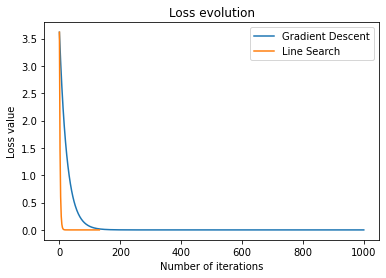

In [24]:
def sum_squared_function(w1, w2):
    value = w1**2 + w2**2 
    return value
def sum_squared_jacobian(w1, w2):
    jacobian = np.array([2*w1,
                         2*w2])
    return jacobian
x0 = np.random.randn(2)
print('Numerical error - Analytical/Numerical jacobian: ',\
      scipy.optimize.check_grad(lambda x: sum_squared_function(x[0], x[1]),\
                                lambda x:  sum_squared_jacobian(x[0], x[1]), x0))

w_init = np.random.randn(2)
w_opt_gd, loss_gd = gradient_descent(w_init, sum_squared_function, sum_squared_jacobian, nb_max_iter=1000, tolerance=.00001)
w_opt_ls, loss_ls = line_search(w_init, sum_squared_function, sum_squared_jacobian, nb_max_iter=1000, tolerance=.00001)

plt.plot(loss_gd, label='Gradient Descent')
plt.plot(loss_ls, label='Line Search')
plt.xlabel("Number of iterations")
plt.ylabel("Loss value")
plt.legend(loc="upper right")
plt.title('Loss evolution')
plt.show()

and $f:(x_i,x_j)\to (x_i^2+x_j-11)^2 + (x_i+x_j^2-7)$ 

Numerical error - Analytical/Numerical jacobian:  6.291244430359654e-07


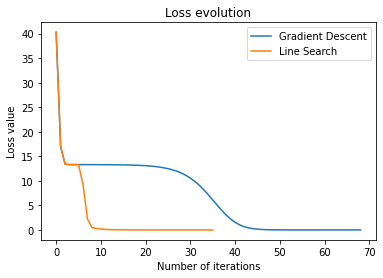

In [25]:
def himmelblau_function(w1,w2):
    return (w1**2+w2-11)**2 + (w1+w2**2-7)**2
# Jacobian
def himmelblau_jacobian(w1,w2):
    jacobian = np.array([4*w1**3+4*w1*w2-42*w1+2*w2**2-14,
                         2*w1**2+4*w1*w2+4*w2**3-26*w2-22])
    return jacobian
x0 = np.random.randn(2)
print('Numerical error - Analytical/Numerical jacobian: ',\
      scipy.optimize.check_grad(lambda x: himmelblau_function(x[0],x[1]),
                                lambda x: himmelblau_jacobian(x[0],x[1]),
                                x0))

w_init = np.random.randn(2)
w_opt_gd, loss_gd = gradient_descent(w_init, himmelblau_function, himmelblau_jacobian, nb_max_iter=1000, tolerance=.00001)
w_opt_ls, loss_ls = line_search(w_init, himmelblau_function, himmelblau_jacobian, nb_max_iter=1000, tolerance=.00001)

plt.plot(loss_gd, label='Gradient Descent')
plt.plot(loss_ls, label='Line Search')
plt.xlabel("Number of iterations")
plt.ylabel("Loss value")
plt.legend(loc="upper right")
plt.title('Loss evolution')
plt.show()

Let's compare the vanilla gradient descent with other aternatives: Nesterov-momentum, AdaGrad, RMS-Prop

* Nesterov-Momentum

In [26]:
def gradient_descent_nesterov(w_init, function, jacobian_function, rho=0.3, alpha=0.1, nb_max_iter=100, tolerance=.00001):
    history_loss = []
    cpt_iter = 0
    # Initialising v and w
    v = 0
    w = w_init
    while cpt_iter < nb_max_iter:
        w_prev = w
        history_loss.append(function(*w))
        J = jacobian_function(*w)
        # Update Rule
        v_ = rho * v - alpha * J
        w = w + v + rho * (v_-v)
        v_ = v
        if np.sqrt(np.sum((w-w_prev)**2)) / (np.sqrt(np.sum(w**2)) + 1e-8) < tolerance:
            break
        cpt_iter += 1
    return w, history_loss

* AdaGrad

In [27]:
def gradient_descent_adagrad(w_init, function, jacobian_function, alpha=0.1, nb_max_iter=100, tolerance=.00001):
    history_loss = []
    cpt_iter = 0
    # Initialising w and grad_w
    w = w_init
    grad_w = np.zeros_like(w_init)
    while cpt_iter < nb_max_iter:
        w_prev = w
        history_loss.append(function(*w))
        J = jacobian_function(*w)
        # Update Rule - Begin
        grad_w = grad_w + J**2
        w = w - alpha / np.sqrt(grad_w + 1e-8) * J
        # Update Rule - End
        if np.sqrt(np.sum((w-w_prev)**2)) / (np.sqrt(np.sum(w**2)) + 1e-8) < tolerance:
            break
        cpt_iter += 1
    return w, history_loss

* RMS-Prop

In [28]:
def gradient_descent_rmsprop(w_init, function, jacobian_function, gamma=0.3, alpha=0.1, nb_max_iter=100, tolerance=.00001):
    history_loss = []
    cpt_iter = 0
    # Initialising w and grad_w
    w = w_init
    grad_w = np.zeros_like(w_init)
    while cpt_iter < nb_max_iter:
        w_prev = w
        history_loss.append(function(*w))
        J = jacobian_function(*w)
        # Update Rule - Begin
        grad_w = gamma * grad_w + (1-gamma) * J**2
        w = w - alpha / np.sqrt(grad_w + 1e-8) * J
        # Update Rule - End
        if np.sqrt(np.sum((w-w_prev)**2)) / (np.sqrt(np.sum(w**2)) + 1e-8) < tolerance:
            break
        cpt_iter += 1
    return w, history_loss

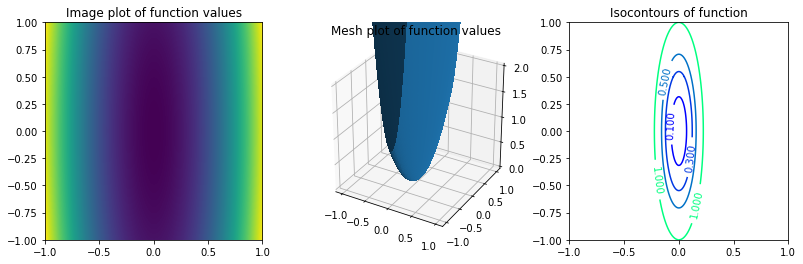

In [29]:
def bad_cond_function(x1,x2):
    return 20 * x1**2 + x2**2
def bad_cond_jacobian(x1,x2):
    jacobian = np.array([40*x1,
                         2*x2])
    return jacobian
    
num_of_points = 201
# Linearly sample the [-1,1] interval with the given number of points.
x1 = np.linspace(-1.0, 1.0, num=num_of_points)
x2 = np.linspace(-1.0, 1.0, num=num_of_points)
# Create a rectangular grid out of the x1 and x2 values.
X1, X2 = np.meshgrid(x1, x2, sparse=False)
visualization_func(X1, X2, bad_cond_function(X1,X2), contour_values=[0.1,0.3,0.5, 1.0])

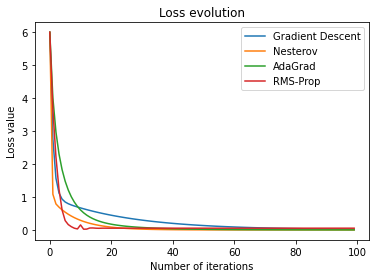

Results from Gradient Descent:  [ 3.26659312e-23 -1.32619556e-01]
Results from Nesterov-Momentum:  [ 6.33825300e-71 -2.05487477e-03]
Results from Adagrad:  [ 5.56054774e-06 -2.73868819e-02]
Results from RMS-Prop:  [-0.05        0.04999997]


In [30]:
w_init = np.array([0.5,-1])
w_gd, loss_gd = gradient_descent(w_init, bad_cond_function, bad_cond_jacobian)
w_nesterov, loss_nesterov = gradient_descent_nesterov(w_init, bad_cond_function, bad_cond_jacobian)
w_adagrad, loss_adagrad = gradient_descent_adagrad(w_init, bad_cond_function, bad_cond_jacobian)
w_rmsprop, loss_rmsprop = gradient_descent_rmsprop(w_init, bad_cond_function, bad_cond_jacobian)


plt.plot(loss_gd, label='Gradient Descent')
plt.plot(loss_nesterov, label='Nesterov')
plt.plot(loss_adagrad, label='AdaGrad')
plt.plot(loss_rmsprop, label='RMS-Prop')
plt.xlabel("Number of iterations")
plt.ylabel("Loss value")
plt.legend(loc="upper right")
plt.title('Loss evolution')
plt.show()

print('Results from Gradient Descent: ', w_gd)
print('Results from Nesterov-Momentum: ', w_nesterov)
print('Results from Adagrad: ', w_adagrad)
print('Results from RMS-Prop: ', w_rmsprop)

## Third Approach: Second-order optimisation

A more stable optimisation can be achieved with second-order derivatives. Let's implement the Newton-Raphson algorithm. The algorithm is iteratively improving the weight value with the following update equation at each step:
$$w^{(i+1)}= w^{(i)} - H(X,w^{(i)})^{-1}J(X,w^{(i)})$$

We can consider that convergence is achieved when the marginal update for $w$ is very small, i.e. $||\mathbf{w}^{t} - \mathbf{w}^{t-1}|| < \epsilon ||\mathbf{w}^t||$

In [31]:
def newton_raphson(w_init, function, jacobian_function, hessian_function, nb_max_iter=100, tolerance=.00001):
    loss = []
    cpt_iter = 0
    w = w_init
    while cpt_iter < nb_max_iter:
        w_prev = w
        loss.append(function(w))
        J = jacobian_function(w)
        H = hessian_function(w)
        w = w - np.linalg.solve(H, J)
        if np.sqrt(np.sum((w-w_prev)**2)) / (np.sqrt(np.sum(w**2)) + 1e-8) < tolerance:
            break
        cpt_iter += 1
    return w, loss

Results with $f:(x_i,x_j)\to x_i^2+x_j^2$ 

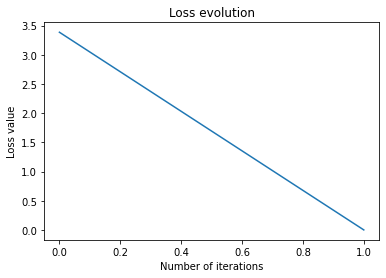

In [32]:
def sum_squared_function(w):
    value = np.sum(w**2)
    return value
def sum_squared_jacobian(w):
    jacobian = 2 * w
    return jacobian
def sum_squared_hessian(w):
    hessian = 2 * np.eye(len(w))
    return hessian
w_init = np.random.randn(3)
w_opt, loss = newton_raphson(w_init, sum_squared_function, sum_squared_jacobian, sum_squared_hessian, nb_max_iter=10000)

plt.plot(loss)
plt.xlabel("Number of iterations")
plt.ylabel("Loss value")
plt.title('Loss evolution')
plt.show()

## Applying Gradient Descent and Stochastic Gradient Descent on mockup data

Let's generate some noisy random values from $f:(x_i,x_j)\to sin(\alpha x_i + \beta x_j)$ with a given set of values for $\alpha$ and $\beta$

In [33]:
def sinus(x1, x2, w):
    return np.sin(w[0] * x1 + w[1] * x2)

In [34]:
n = 1000
noise_scale = 0.001
alpha_gt = np.random.randn()
beta_gt = np.random.randn()
x1 = np.random.rand(n)
x2 = np.random.rand(n)
y = sinus(x1, x2, np.array([alpha_gt, beta_gt]))
noisy_y = y + noise_scale * np.random.randn(n)

The jacobian value of the sinus function can be easily computed:

In [35]:
def jacobian_sinus(x1, x2, w):
    jacobian = np.stack((x1 * np.cos(w[0] * x1 + w[1] * x2),
                        x2 * np.cos(w[0] * x1 + w[1] * x2)), axis=0)
    return jacobian

Let's now define our loss function as an L2 loss: $\mathcal{L} = ||sin(\alpha x_i + \beta x_j)-y||^2$

In [36]:
def loss(x1, x2, y, w):
    loss_value = np.sum((sinus(x1, x2, w) - y)**2)
    return loss_value

In [37]:
def jacobian_loss(x1, x2, y, w):
    g_sinus = jacobian_sinus(x1, x2, w)
    jacobian = 2 * g_sinus * np.expand_dims((sinus(x1, x2, w) - y), axis=0)
    jacobian = np.sum(jacobian, axis=1)
    return jacobian

In [38]:
def gradient_descent(w_init, x1, x2, y, loss, jacobian_loss, step_size=0.001, nb_max_iter=100, tolerance=.00001):
    history_loss = []
    cpt_iter = 0
    w = w_init
    while cpt_iter < nb_max_iter:
        w_prev = w
        history_loss.append(loss(x1, x2, y, w))
        J = jacobian_loss(x1, x2, y, w)
        w = w - step_size * J
        if np.sqrt(np.sum((w-w_prev)**2)) / (np.sqrt(np.sum(w**2)) + 1e-8) < tolerance:
            break
        cpt_iter += 1
    return w, history_loss

In [39]:
def stochastic_gradient_descent(w_init, x1, x2, y, loss, jacobian_loss, step_size=0.001, nb_max_iter=100, tolerance=.00001):
    history_loss = []
    cpt_iter = 0
    w = w_init
    while cpt_iter < nb_max_iter:
        idx = np.random.choice(len(x1), 100)
        x1_ = x1[idx]
        x2_ = x2[idx]
        y_ = y[idx]
        w_prev = w
        history_loss.append(loss(x1, x2, y, w))
        J = jacobian_loss(x1_, x2_, y_, w)
        w = w - step_size * J
        if np.sqrt(np.sum((w-w_prev)**2)) / (np.sqrt(np.sum(w**2)) + 1e-8) < tolerance:
            break
        cpt_iter += 1
    return w, history_loss

GT Value:  [ 0.78771274 -1.0778419 ]  with loss:  0.0009729497692836407
Estimation from GD:  [ 0.78774015 -1.07785278]  with loss:  0.0009728266052997565
Estimation from SGD:  [ 0.78771946 -1.07788272]  with loss:  0.0009734605816390384


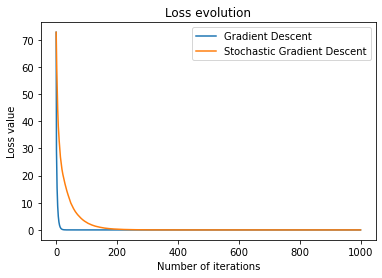

In [40]:
w_init = np.random.randn(2)
print('GT Value: ', np.array([alpha_gt, beta_gt]), ' with loss: ', loss(x1, x2, noisy_y, np.array([alpha_gt, beta_gt])))
w_gd, loss_gd = gradient_descent(w_init, x1, x2, noisy_y, loss, jacobian_loss, nb_max_iter=1000, tolerance=0)
print('Estimation from GD: ', w_gd, ' with loss: ', loss(x1, x2, noisy_y, w_gd))
w_sgd, loss_sgd = stochastic_gradient_descent(w_init, x1, x2, noisy_y, loss, jacobian_loss, nb_max_iter=1000, tolerance=0)
print('Estimation from SGD: ', w_sgd, ' with loss: ', loss(x1, x2, noisy_y, w_sgd))

plt.plot(loss_gd, label='Gradient Descent')
plt.plot(loss_sgd, label='Stochastic Gradient Descent')
plt.xlabel("Number of iterations")
plt.ylabel("Loss value")
plt.legend(loc="upper right")
plt.title('Loss evolution')
plt.show()